In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from numpy import linalg as lg
import illustris_python as il
import pandas as pd
import physics

#intitial setup
basePath = "../data/tng-100-3/output"
fields = {"stars": ["Coordinates", "Potential", "Masses", "Velocities"],
        "gas": ["Coordinates", "Potential", "Masses", "Velocities"],
        "dm": ["Coordinates", "Potential", "Velocities"]
        }
indices = [544, 953, 1285, 1662]
#[1893, 2164, 3043, 3229, 3403, 3605, 3760] 
#np.genfromtxt("./data/tng-100-3/cutdata/early_type_indices.csv")
DM_PARTICLE_MASS = 0.03235675 #found in header of snapshot
N = len(indices)
stars = [0]*N
gas = [0]*N
dm = [0]*N
particle_lists= [gas, dm, stars]
group_cat = pd.DataFrame({"id": indices})


In [2]:
#Load all particles
for i in range(N):
    stars[i] = il.pandasformat.dict_to_pandas(il.snapshot.loadSubhalo(basePath, 99, indices[i], 'stars', fields["stars"]))
    gas[i] = il.pandasformat.dict_to_pandas(il.snapshot.loadSubhalo(basePath, 99, indices[i], 'gas', fields["gas"]))
    dm[i] = il.pandasformat.dict_to_pandas(il.snapshot.loadSubhalo(basePath, 99, indices[i], 'dm', fields["dm"]))
    dm[i]["Masses"] = [DM_PARTICLE_MASS]*len(dm[i]["Potential"]) #Add dm masses

subhaloFields = ["SubhaloMass", 'SubhaloMassType', "SubhaloMassInHalfRadType", "SubhaloHalfmassRadType", "SubhaloPos", "SubhaloVel", "SubhaloSpin"]
subhalos = il.groupcat.loadSubhalos(basePath, 99, fields=subhaloFields)
df_subhalos = il.pandasformat.dict_to_pandas(subhalos)

In [3]:
#calculate radius
def relative_pos_radius(particles, N, catalogue):
    """
    Finds the center of the subhalo by locating  the particle with the lowest gravitational potential.
    Saves this to group catalogue.
    Calculates the relative positions of all particles and adds the new fields to dataframe.
    Calculates distance from center (radius) for all particles and adds the field to dataframe.
    """
    def radius(df):
        x = np.array(df["x"])
        y = np.array(df["y"])
        z = np.array(df["z"])
        r = (x**2 + y**2 + z**2)**(1/2)
        return r

    center_of_halo = np.zeros([N,3]) #list for saving the central positions for all subhalos
    for i in range(N):
        #find center of halo
        min_pot = 0 #all grav pot is <0
        for particle in particles: #look through all particle types for lowest potential
            #Find particle with lowest potential
            min_pot_value = particle[i]["Potential"].min()
            if min_pot_value < min_pot:
                min_pot = min_pot_value
                #Get particle position and assign as center of galaxy
                min_pot_pos = particle[i][particle[i]["Potential"] == min_pot_value]["Coordinates"].values[0]
        
        center_of_halo[i] = min_pot_pos
        #Calculate new coordinates
        for particle in particles:
            positions = np.array(list(particle[i]["Coordinates"].values))
            particle[i]["x"] = positions[:,0] - min_pot_pos[0]
            particle[i]["y"] = positions[:,1] - min_pot_pos[1]
            particle[i]["z"] = positions[:,2] - min_pot_pos[2]
            particle[i]["r"] = radius(particle[i])
    #Save to group catalogue
    catalogue["SubhaloPosX"] = center_of_halo[:,0]
    catalogue["SubhaloPosY"] = center_of_halo[:,1]
    catalogue["SubhaloPosZ"] = center_of_halo[:,2]
    return particles, catalogue

particle_lists, group_cat = physics.properties.relative_pos_radius(particle_lists, N, group_cat)

In [4]:
def total_mass(particles, N, catalogue):
    """
    Calculate total mass for each particle type and saves it to the group catalogue
    """
    particle_mass = np.zeros([len(particles), N])
    p = 0
    for particle in particles:
        for i in range(N):
            particle_mass[p][i] = particle[i]["Masses"].sum() #or load from snapshot to save time
        p = p + 1
    mass_total = particle_mass.sum()

    #save value to catalogue
    catalogue["SubhaloMassGas"] = particle_mass[0]
    catalogue["SubhaloMassDM"] = particle_mass[1]
    catalogue["SubhaloMassStellar"] = particle_mass[2]
    catalogue["SubhaloMass"] = mass_total
    return particles, catalogue
    
particle_lists, group_cat = physics.properties.total_mass(particle_lists, N, group_cat)


In [5]:
j = 0
for i in indices: 
    print("Group catalogue: ", df_subhalos["SubhaloMassStellar"][i], " Snapshot: ", group_cat["SubhaloMassStellar"][j])
    j = j +1

Group catalogue:  80.1757  Snapshot:  80.17588806152344
Group catalogue:  90.369896  Snapshot:  90.3699951171875
Group catalogue:  43.96099  Snapshot:  43.97459030151367
Group catalogue:  42.83398  Snapshot:  42.84111404418945


In [6]:
def subhalo_velocity(particles, N, catalogue):
    """
    Calculates the mass weighted average velocity of the particles in a subhalo and save them to the group catalogue.
    """
    subhalo_velocities = np.zeros([N, 3]) #Empty list
    for i in range(N):
        v_m_sum = np.zeros([len(particles), 3]) #List for saving the sum of velocities*mass for each particle type
        j = 0
        masses = np.zeros(len(particles))
        for particle in particles:
            m = np.array(particle[i]["Masses"]) 
            masses[j] = np.sum(m)
            velocities = np.array(list(particle[i]["Velocities"].values))
            #Velocity times mass for each particle
            vx_m = velocities[:,0]*m
            vy_m = velocities[:,1]*m
            vz_m = velocities[:,2]*m
            v_m_sum[j] = [vx_m.sum(), vy_m.sum(), vz_m.sum()]
            j = j + 1 
        M_tot = masses.sum() #total mass of subhalo
        subhalo_velocities[i] = np.sum(v_m_sum, axis=0)/M_tot #Mass weighted average velocity
    #save to group catalogue
    catalogue["SubhaloVelocityX"] = subhalo_velocities[:,0]
    catalogue["SubhaloVelocityY"] = subhalo_velocities[:,1]
    catalogue["SubhaloVelocityZ"] = subhalo_velocities[:,2]
    return particles, catalogue
particle_lists, group_cat = physics.properties.subhalo_velocity(particle_lists, N, group_cat)


In [7]:
for i in range(N):
    print(group_cat["SubhaloVelocityX"][i])
    print(subhalos["SubhaloVel"][indices[i]])

-175.11496411068748
[-175.13785    81.367256   -8.339443]
279.265925652316
[279.23257  -99.84879   82.072495]
174.67770423321207
[174.64732  57.31744 170.41402]
99.06664108015092
[ 99.0264  291.83783 138.21898]


In [8]:
def relative_velocities(particle, N, catalogue):
    """
    Adds the relative velocity to the dataframes of a chosen particle type.
    """
    central_vel = np.zeros([N,3]) #empty list
    for i in range (N):
        vel_av = [catalogue["SubhaloVelocityX"][i], catalogue["SubhaloVelocityY"][i], catalogue["SubhaloVelocityZ"][i]]
        velocities = np.array(list(particle[i]["Velocities"].values))
        vx = velocities[:,0]
        vy = velocities[:,1]
        vz = velocities[:,2]
        #Subtracts subhalo velocity from global velocities to get local velocities
        particle[i]["Vx"] = vx - vel_av[0]
        particle[i]["Vy"] = vy - vel_av[1]
        particle[i]["Vz"] = vz - vel_av[2]
    return particle, catalogue
stars, group_cat = relative_velocities(stars, N, group_cat)

In [9]:
def half_mass_radius(particle, N, catalogue, particle_type="Stellar"):
    """
    Calculates half mass radius for a certain particle type and adds it to the group catalogue.
    """
    halfmass_rad = np.zeros(N) #empty list
    mass_key = "SubhaloMass" + particle_type
    rad_key = "SubhaloHalfmassRad" + particle_type
    for i in range(N):
        temp = particle[i].copy(deep=True)
        temp = temp.sort_values(by="r") #sort particles by radius
        temp_mass = 0
        #Start adding the masses of all particles starting with smallest radius
        for j in range(len(temp["r"])):
            #Check if total mass is less than half total particle mass
            if temp_mass < (catalogue[mass_key][i]/2):
                temp_mass = temp_mass + temp["Masses"][j] #Add mass of next particle
            else:
                #Add half mass radius. 
                #Some uncertainty on calculation method here, now center of mass between particle j and j-i
                m1 = temp["Masses"][j-1]
                m2 = temp["Masses"][j]
                M = m1+m2
                halfmass_rad[i] = (m1*temp["r"][j-1] + m2*temp["r"][j])/M
                break  #stop loop
    catalogue[rad_key] = halfmass_rad #save to catalogue
    return particle, catalogue

stars, group_cat = half_mass_radius(stars, N, group_cat, "Stellar")

In [10]:
j = 0
for i in indices: 
    print("Group catalogue: ", df_subhalos["SubhaloHalfmassRadStellar"][i], " Snapshot: ", group_cat["SubhaloHalfmassRadStellar"][j])
    j = j +1

Group catalogue:  64.70497  Snapshot:  57.03927079687098
Group catalogue:  79.047134  Snapshot:  81.96062358633587
Group catalogue:  33.925236  Snapshot:  43.439945028308486
Group catalogue:  40.62605  Snapshot:  42.503865196913104


In [11]:
def max_ang_momentum(particle, N, catalogue):
    max_h_dir = np.zeros([N, 3])
    for i in range(len(particle)):
        r_max = 5*catalogue["SubhaloHalfmassRadStellar"][i]
        temp = particle[i][particle[i]["r"] < r_max].copy(deep=True)
        h_len = np.zeros(len(temp["r"]))
        v = np.array([np.array(temp["Vx"]), np.array(temp["Vy"]), np.array(temp["Vz"])])
        r = np.array([np.array(temp["x"]), np.array(temp["y"]), np.array(temp["z"])])
        h = np.cross(np.transpose(r), np.transpose(v))
        for j in range (len(h)):
            h_len[j] = np.linalg.norm(h[j])
        h_max, max_index = h_len.max(), h_len.argmax()
        print(max_index, len(h))
        max_h_dir[i] = [h[max_index][0], h[max_index][1], h[max_index][2]]/h_max
        #print(v[0][L_max_index], v[1][L_max_index], v[2][L_max_index])
        #L_avg = [Lx.mean(), Ly.mean(), Lz.mean()]
        #max_L_dir[i] = L_avg/np.linalg.norm(L_avg)
    catalogue["RotationAxisX"] = [item[0] for item in max_h_dir]
    catalogue["RotationAxisY"] = [item[1] for item in max_h_dir]
    catalogue["RotationAxisZ"] = [item[2] for item in max_h_dir]

    return catalogue

group_cat = max_ang_momentum(stars, N, group_cat)



14432 14443
18122 18123
8134 8150
7779 7789


In [12]:
rot_vector = np.transpose(np.array([group_cat["RotationAxisX"], group_cat["RotationAxisY"], group_cat["RotationAxisZ"]]))
for i in range(N):
    s_vec = np.array(subhalos["SubhaloSpin"][indices[i]])
    s = np.linalg.norm(s_vec)
    s_dir = s_vec/s
    s_check = np.linalg.norm(s_dir)
    t_check = np.linalg.norm(rot_vector[i])
    print("snapshot: ", rot_vector[i], t_check)
    print("catalogue: ", s_dir, s_check)

snapshot:  [-0.02224239  0.71470927  0.6990679 ] 1.0
catalogue:  [ 0.21661627 -0.66537654 -0.7143889 ] 1.0
snapshot:  [ 0.28336521 -0.95030478  0.12893789] 0.9999999999999999
catalogue:  [ 0.18161198 -0.07396439 -0.9805847 ] 0.99999994
snapshot:  [-0.3872053  -0.56906234  0.72542409] 1.0
catalogue:  [-0.28974828 -0.75167984  0.5924722 ] 1.0
snapshot:  [-0.24791186 -0.96471996 -0.08862911] 1.0
catalogue:  [-0.01974839 -0.5753676   0.8176564 ] 0.99999994


In [13]:
def rotate_coordinates(particles, N, catalogue, rot_vector):
    """
    Rotates the coordinates of the particles such that the z-sxis aligns with rot_vector.
    """
    def rotate_basis(new_z_axis):
        """
        Returns the rotation matrix for a rotation where the new z-axis is alligned with the axis "new_z_axis".
        """
        old_basis = np.identity(3)
        v = new_z_axis
        v_xy = np.array([v[0], v[1], 0])
        theta = np.nan_to_num(np.arccos(np.dot(v/lg.norm(v), old_basis[:, 2]))) #get angle between new z axis and old z axis
        phi = np.nan_to_num(np.arccos(np.dot(v_xy/lg.norm(v_xy), old_basis[:, 0]))) #get angle between projected new z axis and old x axis
        #Rotate phi radians about z and theta radians about y
        r = R.from_euler('zyx', [phi, theta, 0])
        rot_matrix = np.array(r.as_matrix()) #convert to numpy array
        return rot_matrix
    #Go through all subhalos   
    for i in range (N):
        rotation_matrix = rotate_basis(rot_vector[i])
        print("Rotating galaxy ", i) #This function takes a lot of time
        for particle in particles:
            temp = particle[i].copy(deep=True)
            old_positions = np.transpose(np.array([temp["x"], temp["y"], temp["z"]])) #get coordinates in vector form
            new_positions = np.zeros([len(old_positions), 3]) #empty list
            for j in range(len(old_positions)): #If this could be done faster, code would improve
                new_positions[j] = np.dot(rotation_matrix, np.transpose(old_positions[j]))# r' = Rr
            #new_positions = np.transpose(new_positions)
            particle[i]["x_rot"] = new_positions[:, 0]
            particle[i]["y_rot"] = new_positions[:, 1]
            particle[i]["z_rot"] = new_positions[:, 2]
    return particles

rot_vector = np.transpose(np.array([group_cat["RotationAxisX"], group_cat["RotationAxisY"], group_cat["RotationAxisZ"]]))
particle_lists = physics.geometry.rotate_coordinates(particle_lists, N, group_cat, rot_vector)


Rotating galaxy  0
Rotating galaxy  1
Rotating galaxy  2
Rotating galaxy  3


In [14]:
stars[0].to_pickle("../data/disk_galaxy.pkl")

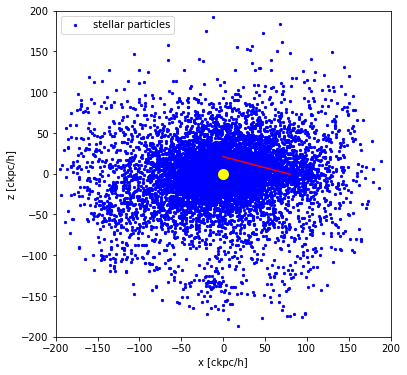

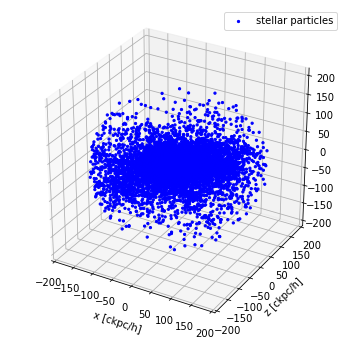

In [15]:
n = 50
g=0
fig1 = plt.figure(figsize = (6,6))
plt.scatter(stars[g][stars[g]["r"] < 200]["x"], stars[g][stars[g]["r"] < 200]["z"], c = "blue", s=5, alpha = 1, label ="stellar particles")
plt.scatter(stars[g]["x"][n], stars[g]["z"][n], c = "yellow", s=100, alpha = 1)
plt.plot([80, 0],[group_cat["RotationAxisX"][g]*30, group_cat["RotationAxisZ"][g]*30], c = "red")
plt.xlim([-200, 200])
plt.ylim([-200, 200])
plt.xlabel('x [ckpc/h]')
plt.ylabel('z [ckpc/h]')
plt.legend()
plt.show()

fig2 = plt.figure(figsize = (6,6))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(stars[g][stars[g]["r"] < 200]["x"], stars[g][stars[g]["r"] < 200]["y"], stars[g][stars[g]["r"] < 200]["z"], c = "blue", s=5, alpha = 1, label ="stellar particles")

plt.xlim([-200, 200])
plt.ylim([-200, 200])
plt.xlabel('x [ckpc/h]')
plt.ylabel('z [ckpc/h]')
plt.legend()
plt.show()


In [16]:
rot_vector = np.transpose(np.array([group_cat["RotationAxisX"], group_cat["RotationAxisY"], group_cat["RotationAxisZ"]]))
for i in range(N):
    #print(stars[i][stars[i]["r"] < 50]["Vz"].max())
    print(subhalos["SubhaloVel"][indices[i]])

[-175.13785    81.367256   -8.339443]
[279.23257  -99.84879   82.072495]
[174.64732  57.31744 170.41402]
[ 99.0264  291.83783 138.21898]


In [17]:
rot_vector = np.transpose(np.array([group_cat["RotationAxisX"], group_cat["RotationAxisY"], group_cat["RotationAxisZ"]]))
for i in range(N):
    s_vec = np.array(subhalos["SubhaloSpin"][indices[i]])
    s = np.linalg.norm(s_vec)
    s_dir = s_vec/s
    #print(stars[i][stars[i]["r"] < 50]["Vz"].max())
    print("snapshot: ", rot_vector[i])
    print("catalogue: ", s_dir)

snapshot:  [-0.02224239  0.71470927  0.6990679 ]
catalogue:  [ 0.21661627 -0.66537654 -0.7143889 ]
snapshot:  [ 0.28336521 -0.95030478  0.12893789]
catalogue:  [ 0.18161198 -0.07396439 -0.9805847 ]
snapshot:  [-0.3872053  -0.56906234  0.72542409]
catalogue:  [-0.28974828 -0.75167984  0.5924722 ]
snapshot:  [-0.24791186 -0.96471996 -0.08862911]
catalogue:  [-0.01974839 -0.5753676   0.8176564 ]
